## Import Libraries

In [149]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix 
from scipy.spatial.distance import cdist
from skimage.measure import label, regionprops, moments, moments_central, moments_normalized, moments_hu
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import io, exposure
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 
import pickle
import cv2
plt.rcParams["figure.figsize"] = (20,3)

## Data PreProcessing Techniques

In [139]:
def face_detection(img):
    # Read image from your local file system
    original_image = img
    # Convert color image to grayscale for Viola-Jones
    grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    # Load the classifier and create a cascade object for face detection
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
    detected_faces = face_cascade.detectMultiScale(grayscale_image)
    for (column, row, width, height) in detected_faces:
        cv2.rectangle(
            original_image,
            (column, row),
            (column + width, row + height),
            (0, 255, 0),
            2
        )
        sub_face = img[row:row+height, column:column+width]
    return sub_face

#https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html
def smoothing(img, d=5, sigmaColor=65, sigmaSpace=65):
    blur_img = cv2.bilateralFilter(img,d,sigmaColor,sigmaSpace)
    return blur_img

#https://docs.opencv.org/3.4/d4/d1b/tutorial_histogram_equalization.html
def histogram_equalization(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dst = cv2.equalizeHist(img)
    return dst


## Data Download, Preperation and Explorationa, PreProcessing

In [150]:
# get one image function and resize
def get_image(emotion_folders, emotion, img,is_filter=False, filters=None, log_it=False):
    input_img=cv2.imread(emotion_folders + '/'+ emotion + '/'+ img )
    if is_filter and filters == '1':
        input_img = smoothing(input_img)
    elif is_filter and filters == '2':
        input_img = face_detection(input_img)
    elif is_filter and filters == '3':
        input_img = histogram_equalization(input_img)
    input_img_resize=cv2.resize(input_img,(50,50))
    if log_it:
        print ('Loaded image for emotion: '+str(emotion))
    return input_img_resize

# get one image function and resize
def get_all_images(path, all_emotions_folders,is_filter=False, filters=None, log_it=False):
    emotions_list = os.listdir(path)
    indicies = []
    
    emos = []
    num_emos = []
    
    img_all_data=[]
    log_it=True
    for emotion in emotions_list:
        if emotion !='.DS_Store':
            img_list=os.listdir(path+'/'+ emotion) 
            emos.append(emotion)
            num_emos.append(len(img_list))
            print ('Loaded images for emotion: '+str(emotion)+', number of emotions: '+str(len(img_list)))
            for img in img_list:
                input_img_resize=get_image(path, emotion,img, is_filter, filters, log_it)
                if log_it:
                    indicies.append(len(img_all_data))
                img_all_data.append(input_img_resize)
                log_it=False
            log_it=True
    img_data = np.array(img_all_data)
    # why to divide by 255 The reason is that if the color intensity is a float
    #, then matplotlib expects it to range from 0 to 1. If an int, 
    #then it expects 0 to 255. So you can either force all the numbers to int or scale them all by 1/255.
    #https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa
    img_data = img_data.astype('float32')/255
    return img_data,indicies
def standarize(data_list):
    mean, STD  = cv2.meanStdDev(data_list)
    data_list_standarize = (data_list - mean) / STD
    return data_list_standarize

One image Show
Loaded image for emotion: happy
(50, 50, 3)


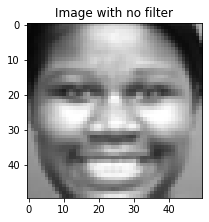

One image with face detection
Loaded image for emotion: happy
(50, 50, 3)


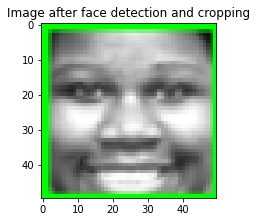

One image with smoothing
Loaded image for emotion: happy
(50, 50, 3)


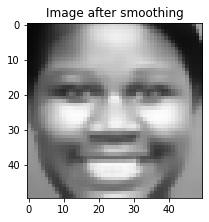

One image with histogram equalization
Loaded image for emotion: happy
(50, 50)


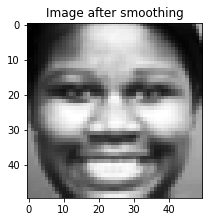

In [151]:
import os, cv2
path = './archive/CK+48'

all_emotions_folders = os.listdir(path)
if '.DS_Store' in all_emotions_folders: all_emotions_folders.remove('.DS_Store')

print("One image Show")
img_list=os.listdir(path+'/'+ all_emotions_folders[0])
first_image = get_image(path, all_emotions_folders[0], img_list[0], is_filter=False, filters=None, log_it=True)
print(first_image.shape)
io.imshow(first_image) 
plt.title('Image with no filter') 
io.show()

print("One image with face detection")
first_image = get_image(path, all_emotions_folders[0], img_list[0], is_filter=True, filters='2', log_it=True)
print(first_image.shape)
io.imshow(first_image) 
plt.title('Image after face detection and cropping') 
io.show()

print("One image with smoothing")
first_image = get_image(path, all_emotions_folders[0], img_list[0], is_filter=True, filters='1', log_it=True)
print(first_image.shape)
io.imshow(first_image) 
plt.title('Image after smoothing') 
io.show()

print("One image with histogram equalization")
first_image = get_image(path, all_emotions_folders[0], img_list[0], is_filter=True, filters='3', log_it=True)
print(first_image.shape)
io.imshow(first_image) 
plt.title('Image after smoothing') 
io.show()

In [152]:
img_data,indicies = get_all_images(path, all_emotions_folders, is_filter=False, filters=None, log_it=True)
img_data_standarize = standarize(img_data)

Loaded images for emotion: happy, number of emotions: 207
Loaded image for emotion: happy
Loaded images for emotion: contempt, number of emotions: 54
Loaded image for emotion: contempt
Loaded images for emotion: fear, number of emotions: 75
Loaded image for emotion: fear
Loaded images for emotion: surprise, number of emotions: 249
Loaded image for emotion: surprise
Loaded images for emotion: sadness, number of emotions: 84
Loaded image for emotion: sadness
Loaded images for emotion: anger, number of emotions: 135
Loaded image for emotion: anger
Loaded images for emotion: disgust, number of emotions: 177
Loaded image for emotion: disgust


In [153]:
indicies

[0, 207, 261, 336, 585, 669, 804]

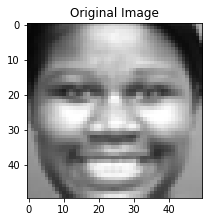

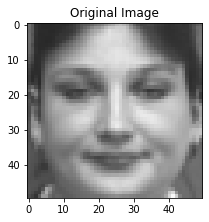

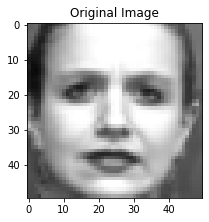

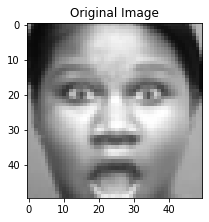

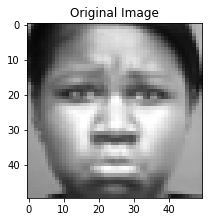

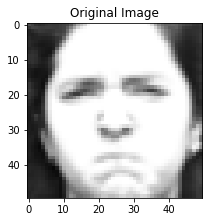

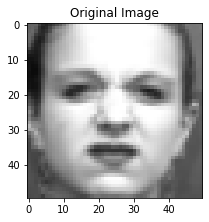

In [154]:
for i in indicies:
    io.imshow(img_data[i]) 
    plt.title('Original Image') 
    io.show()

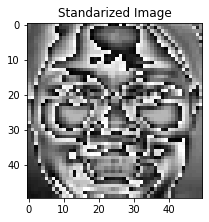

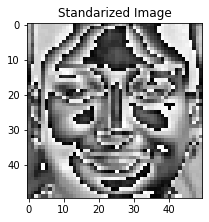

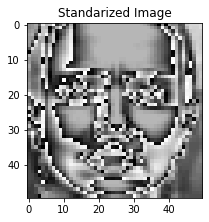

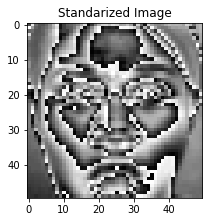

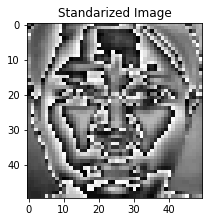

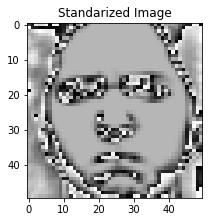

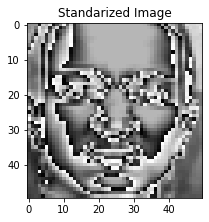

All images data Shape


(981, 50, 50, 3)

In [155]:
for i in indicies:
    io.imshow((img_data_standarize[i]* 255).astype(np.uint8)) 
    plt.title('Standarized Image') 
    io.show()
print("All images data Shape")
img_data_standarize.shape

Loaded images for emotion: happy, number of emotions: 207
Loaded image for emotion: happy
Loaded images for emotion: contempt, number of emotions: 54
Loaded image for emotion: contempt
Loaded images for emotion: fear, number of emotions: 75
Loaded image for emotion: fear
Loaded images for emotion: surprise, number of emotions: 249
Loaded image for emotion: surprise
Loaded images for emotion: sadness, number of emotions: 84
Loaded image for emotion: sadness
Loaded images for emotion: anger, number of emotions: 135
Loaded image for emotion: anger
Loaded images for emotion: disgust, number of emotions: 177
Loaded image for emotion: disgust


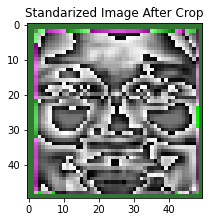

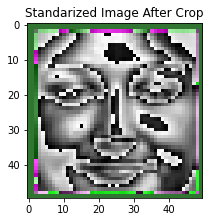

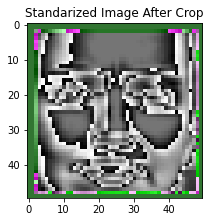

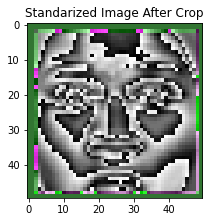

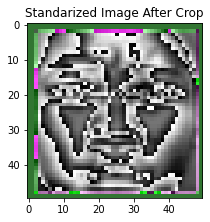

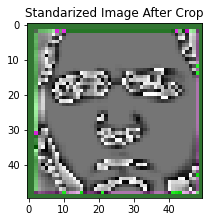

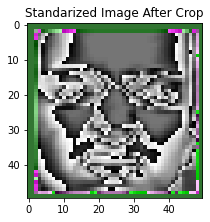

All images data Shape


(981, 50, 50, 3)

In [157]:
img_data_crop,indicies = get_all_images(path, all_emotions_folders, is_filter=True, filters='2', log_it=True)
img_data_crop_standarize = standarize(img_data_crop)
for i in indicies:
    io.imshow((img_data_crop_standarize[i]* 255).astype(np.uint8)) 
    plt.title('Standarized Image After Crop') 
    io.show()
print("All images data Shape")
img_data_crop_standarize.shape

## Model 1 

## Model 2 

## Model 3

## Accuracy and Loss Comparisons

## Results